In [25]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D

# Data

In [2]:
# Load the MNIST dataset

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

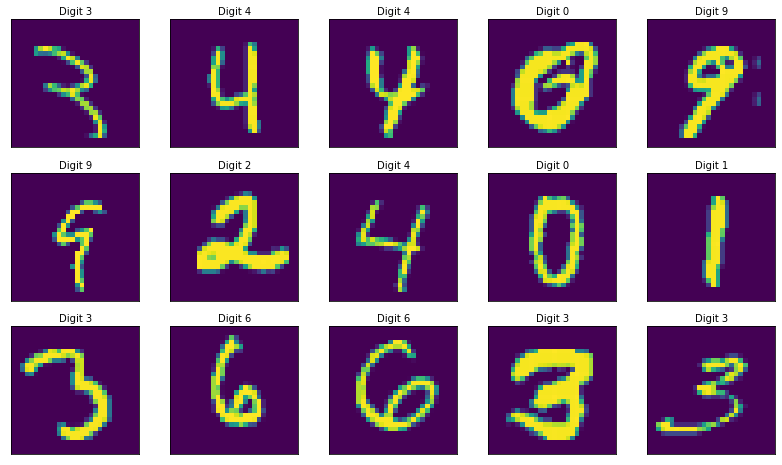

In [3]:
#View some examples in the dataset

n_rows, n_cols = 3, 5
random_inx = np.random.choice(x_train.shape[0], n_rows * n_cols, replace=False)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 8))
fig.subplots_adjust(hspace=0.2, wspace=0.1)

for n, i in enumerate(random_inx):
    row = n // n_cols
    col = n % n_cols
    axes[row, col].imshow(x_train[i])
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)
    axes[row, col].text(10., -1.5, f'Digit {y_train[i]}')
plt.show()

# MLP (94%)

In [6]:
# Create an MNIST classifier model

# input images have dim 28x28. Dense layers requires inputs to be 1 dim array. 
# Flatten unrolls into 1 dim array of length 784 (28x28)
from tensorflow.keras.layers import Flatten, Dense

mnist_model = Sequential([
    Flatten(input_shape=(28,28)),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(10, activation='softmax') # last layer needs 10 neurons, 1 for each digit and use soft max (multi-classification)
])

mnist_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


In [8]:
y_train # is in interger format ==> sparse_cat

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [9]:
#compile it - optimizer and loss fun

mnist_model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

In [10]:
#The image data is filled with integer pixel values from 0 to 255. 
#To facilitate the training, we RESCALE the values to the interval [0, 1].

# Rescale the image data

x_train = x_train/255
x_test = x_test/255

In [11]:
#fit the model

history = mnist_model.fit(x_train, y_train, epochs=10, batch_size=64) 

Epoch 1/10
938/938 [==============================] - 2s 2ms/step - loss: 0.8318 - accuracy: 0.8050
Epoch 2/10
938/938 [==============================] - 1s 1ms/step - loss: 0.4126 - accuracy: 0.8910
Epoch 3/10
938/938 [==============================] - 1s 1ms/step - loss: 0.3436 - accuracy: 0.9045
Epoch 4/10
938/938 [==============================] - 1s 1ms/step - loss: 0.3086 - accuracy: 0.9128
Epoch 5/10
938/938 [==============================] - ETA: 0s - loss: 0.2847 - accuracy: 0.91 - 1s 1ms/step - loss: 0.2850 - accuracy: 0.9186
Epoch 6/10
938/938 [==============================] - 1s 1ms/step - loss: 0.2662 - accuracy: 0.9240
Epoch 7/10
938/938 [==============================] - 1s 1ms/step - loss: 0.2506 - accuracy: 0.9282
Epoch 8/10
938/938 [==============================] - 1s 1ms/step - loss: 0.2371 - accuracy: 0.9317
Epoch 9/10
938/938 [==============================] - 1s 1ms/step - loss: 0.2249 - accuracy: 0.9351
Epoch 10/10
938/938 [==============================] - 1s 

In [12]:
# Evaluate the model on the test set

mnist_model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.2089 - accuracy: 0.9400


[0.2089187204837799, 0.9399999976158142]

In [13]:
# Get predictions from model

preds = mnist_model.predict(x_test)
preds.shape

(10000, 10)

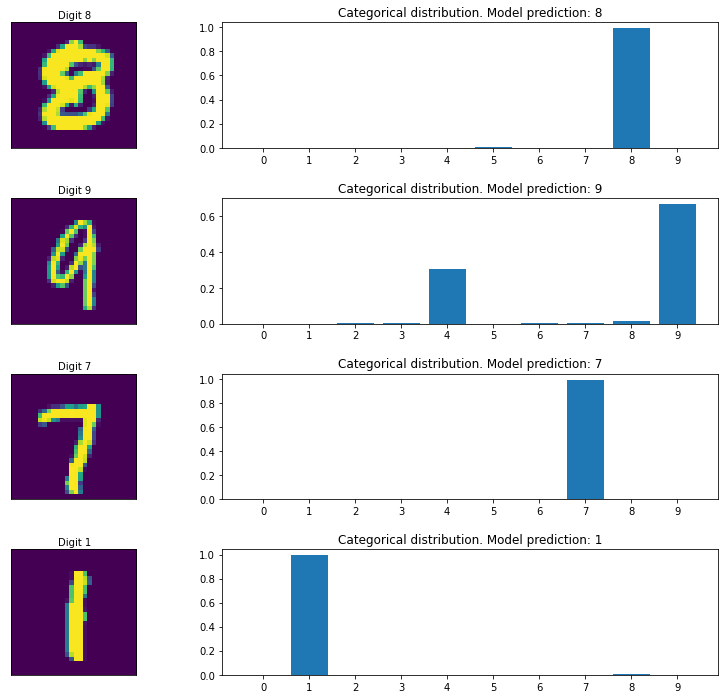

In [14]:
# Plot some predicted categorical distributions

# gets probabilites for 4 randomly selected images from the test set and it 
# is going to display these images along with the predictive distribution of the model
# and the correct label

num_test_images = x_test.shape[0]

random_inx = np.random.choice(num_test_images, 4)
random_preds = preds[random_inx, ...]
random_test_images = x_test[random_inx, ...]
random_test_labels = y_test[random_inx, ...]

fig, axes = plt.subplots(4, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(random_preds, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)}")
plt.show()

# CNN (98%)

In [21]:
#CNN Model - FEATURE EXTRACTION

model_cnn = Sequential([
    # 2D convolutional Layer, with number of filters=8 (this is specifying the output channel dim), kernal =(3,5)
    Conv2D(8, (3,5), activation='relu', input_shape=(28,28,1)),
    # spat out: (28-3+1=26, 28-5+1=24, 8)
    
    #Maxpooling layer, with a (2,2) poolarea (for each 2x2 block in input it takes the max of those 4 values)
    #halves spatial dims (channel dim not effected as pooling is done channel-wise)
    MaxPool2D((2,2)),
    #spat out: (28/2=14, 24/2=12, 8)
    
    #2D convolutional layer, with 16 filters (output channel) and (3,3) kernal
    Conv2D(16, 3, activation='relu'),
    #spat out: (14-3+1=12, 12-3+1=10, 16)
    
    #maxpool layer with (2,2) pool area.
    MaxPool2D(2)
    #spat out: (12/2=6, 10/2=5, 16)
])

model_cnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 24, 8)         128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 12, 8)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 10, 16)        1168      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 16)          0         
Total params: 1,296
Trainable params: 1,296
Non-trainable params: 0
_________________________________________________________________


In [24]:
#need an MLP model to do classification

model_mlp = Sequential([
    Flatten(input_shape=(5,5,16)),
    Dense(100, activation='relu'),
    Dense(10, activation='softmax')
])

model_mlp.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               40100     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1010      
Total params: 41,110
Trainable params: 41,110
Non-trainable params: 0
_________________________________________________________________


In [26]:
#now we combine these two models!

model_comb = Model(model_cnn.input, model_mlp(model_cnn.output))

model_comb.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8_input (InputLayer)  [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 26, 24, 8)         128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 12, 8)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 10, 16)        1168      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
sequential_6 (Sequential)    (None, 10)                41110     
Total params: 42,406
Trainable params: 42,406
Non-trainable params: 0
__________________________________________________

In [27]:
model_comb.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

In [28]:
history = model_comb.fit(x_train, y_train, epochs=10, batch_size=64) 

Epoch 1/10
938/938 [==============================] - 8s 9ms/step - loss: 0.8725 - accuracy: 0.7345
Epoch 2/10
938/938 [==============================] - 7s 8ms/step - loss: 0.2260 - accuracy: 0.9323
Epoch 3/10
938/938 [==============================] - 6s 6ms/step - loss: 0.1616 - accuracy: 0.9520
Epoch 4/10
938/938 [==============================] - 6s 6ms/step - loss: 0.1305 - accuracy: 0.9600
Epoch 5/10
938/938 [==============================] - 6s 6ms/step - loss: 0.1131 - accuracy: 0.9655
Epoch 6/10
938/938 [==============================] - 6s 6ms/step - loss: 0.1001 - accuracy: 0.9693
Epoch 7/10
938/938 [==============================] - 6s 6ms/step - loss: 0.0909 - accuracy: 0.9725
Epoch 8/10
938/938 [==============================] - 6s 6ms/step - loss: 0.0835 - accuracy: 0.9743
Epoch 9/10
938/938 [==============================] - 6s 7ms/step - loss: 0.0768 - accuracy: 0.9765
Epoch 10/10
938/938 [==============================] - 6s 7ms/step - loss: 0.0725 - accuracy: 0.9774

In [29]:
# Evaluate the model on the test set

model_comb.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0676 - accuracy: 0.9792


[0.06762967258691788, 0.979200005531311]

In [30]:
# Get predictions from model

preds = model_comb.predict(x_test)
preds.shape

(10000, 10)

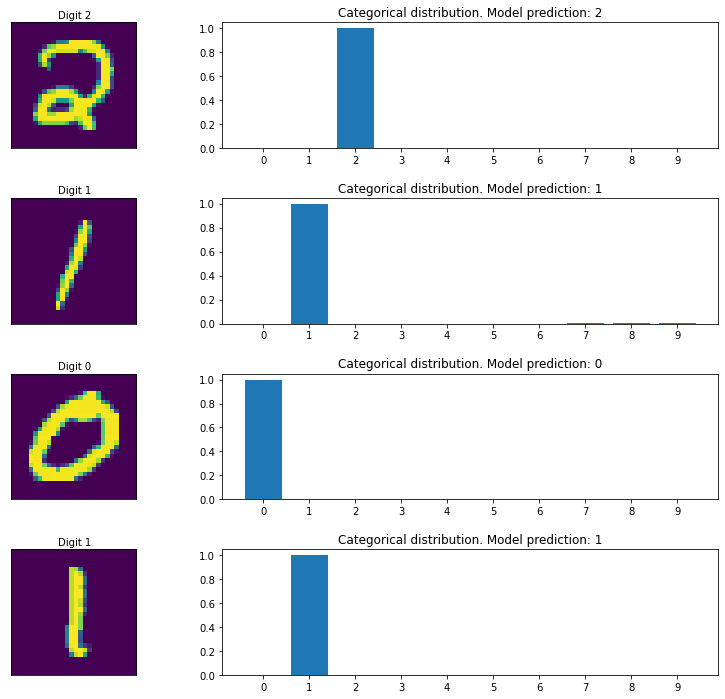

In [31]:
# Plot some predicted categorical distributions

# gets probabilites for 4 randomly selected images from the test set and it 
# is going to display these images along with the predictive distribution of the model
# and the correct label

num_test_images = x_test.shape[0]

random_inx = np.random.choice(num_test_images, 4)
random_preds = preds[random_inx, ...]
random_test_images = x_test[random_inx, ...]
random_test_labels = y_test[random_inx, ...]

fig, axes = plt.subplots(4, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(random_preds, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)}")
plt.show()